Statistics of the sequencing data:
- counts: samples, species
- amplicon recovery
- allele counts per sample
- extent of gaps in the alignment

Manual steps: none

In [1]:
%run common.ipynb

# Read files

In [2]:
seq = pd.read_csv(COMB_SEQ)
display(seq.shape)
seq.sample()

(10057, 6)

,s_Sample,target,consensus,reads,species,combUID
1833,Amac-50,12,TTAATTCGTCATGGTGTTCGGGTGTGGCGGCCGGCCACCATCATGG...,50.0,Anopheles_maculipalpis,12-10


In [3]:
meta = pd.read_csv(COMB_META)
display(meta.shape)
meta.sample()

(164, 17)

,s_Sample,External ID,Date of Collection,Location,Country,Latitude,Longitude,Species,Collection Context,Collection Method,Collection Time,Specimen Sex,Specimen Type,Extraction Method,Sample Type,Sample Set,Source
65,Abro-22,22,2015-01-02,Mvengue,Gabon,-1.63961,13.41353,Anopheles_brohieri,Outdoors,Human Landing Catch,NaN,Female,Wild caught adult,QIAGEN,Genomic DNA,ga,run1


# General stats

In [4]:
# samples per source (run/reference)
meta.groupby('Source')['s_Sample'].nunique()

Source
ref     28
run1    70
run2    62
run9     3
Name: s_Sample, dtype: int64

In [5]:
# samples per sample set
meta.groupby('Sample Set')['s_Sample'].nunique()

Sample Set
ga     89
kh     43
ref    28
sa      3
Name: s_Sample, dtype: int64

In [6]:
# species total
meta.Species.nunique()

58

In [7]:
# species per sample set
meta.groupby('Sample Set')['Species'].nunique()

Sample Set
ga     24
kh     13
ref    23
sa      3
Name: Species, dtype: int64

In [8]:
# samples per species
meta.groupby('Species')['s_Sample'].nunique().describe()

count    58.000000
mean      2.810345
std       1.781552
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max       7.000000
Name: s_Sample, dtype: float64

## Overall missingness

In [9]:
# for some overall statistics, exclude reference-derived data
miseq = seq[~seq.s_Sample.str.startswith('anopheles')]

count    133.000000
mean      46.090226
std       14.358747
min        1.000000
25%       44.000000
50%       50.000000
75%       56.000000
max       62.000000
Name: target, dtype: float64

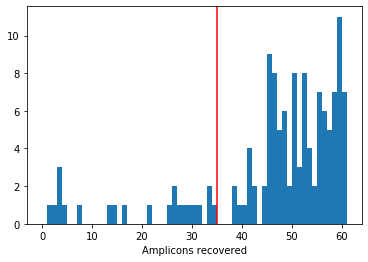

In [10]:
# amplicon recovery per sample
aps = miseq.groupby('s_Sample')['target'].nunique()
display(aps.describe())
plt.hist(aps, bins=range(62))
plt.axvline(35, color='r', linestyle='solid')
plt.xlabel('Amplicons recovered');

count    161.000000
mean      46.732919
std       13.728965
min        1.000000
25%       43.000000
50%       50.000000
75%       57.000000
max       62.000000
Name: target, dtype: float64

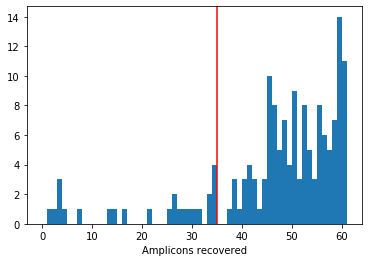

In [11]:
# same, combined with reference data
aps = seq.groupby('s_Sample')['target'].nunique()
display(aps.describe())
plt.hist(aps, bins=range(62))
plt.axvline(35, color='r', linestyle='solid')
plt.xlabel('Amplicons recovered');

## Missingness vs species

In [12]:
# assign taxonomy
def get_taxonomy(species_series, taxonomy):
    tax_df = pd.DataFrame(species_series)
    ampl_counts['subgenus'] =  ampl_counts.species.replace(taxonomy['subgenus'].to_dict())
    ampl_counts['series'] =  ampl_counts.species.replace(taxonomy['series'].to_dict())

In [13]:
# recovered amplicon counts 
ampl_counts = seq.groupby(['species','s_Sample']) \
                    ['target'].nunique() \
                    .reset_index() \
                    .sort_values(ascending=False, 
                                 by=['target','species']) \
                    .rename(columns={'target':'targets_recovered'})
                    

In [14]:
taxonomy = pd.read_csv(TAXONOMY_FILE, index_col=0)

In [15]:
# set subgenera species mapping
ampl_counts['subgenus'] =  ampl_counts.species.replace(taxonomy['subgenus'].to_dict())
ampl_counts['series'] =  ampl_counts.species.replace(taxonomy['series'].to_dict())

ampl_counts.subgenus.value_counts(dropna=False)

Cellia           119
Anopheles         36
Nyssorhynchus      4
Kerteszia          2
Name: subgenus, dtype: int64

In [16]:
ampl_counts.groupby('subgenus')['species'].nunique()

subgenus
Anopheles         9
Cellia           42
Kerteszia         2
Nyssorhynchus     4
Name: species, dtype: int64

In [17]:

# series resolution for cellia
ampl_counts['group'] = ampl_counts['subgenus'] + ' subgenus'
ampl_counts.loc[ampl_counts.subgenus=='Cellia', 'group'] = ampl_counts.loc[ampl_counts.subgenus=='Cellia', 'series'] + ' series'
ampl_counts.group.value_counts(dropna=False)

Neomyzomyia series        37
Anopheles subgenus        36
Myzomyia series           35
Pyretophorus series       27
Neocellia series          20
Nyssorhynchus subgenus     4
Kerteszia subgenus         2
Name: group, dtype: int64

In [18]:
ampl_counts[ampl_counts.group.isna()].species.unique()

array([], dtype=object)

In [19]:
# shorten genus name in species
ampl_counts['species'] = ampl_counts['species'].str.replace('Anopheles_','An. ')
# numeric representation of species
all_spp = ampl_counts.species.drop_duplicates()
spp_no = dict()
for i, sp in enumerate(all_spp):
    spp_no[sp] = i
ampl_counts['species_no'] = ampl_counts['species'].replace(spp_no)
# jitter in case of equal targets recovered
j = .4
for spn in ampl_counts.species_no.unique():
    acs = ampl_counts[ampl_counts.species_no == spn]
    for tr in acs.targets_recovered.unique():
        nseq = acs[acs.targets_recovered == tr].shape[0]
        upd_spn = [spn + i * j - j * (nseq - 1) / 2 for i in range(nseq)] 
        ampl_counts.loc[(ampl_counts.species_no == spn) & 
                        (ampl_counts.targets_recovered == tr), 'species_no'] = upd_spn
            

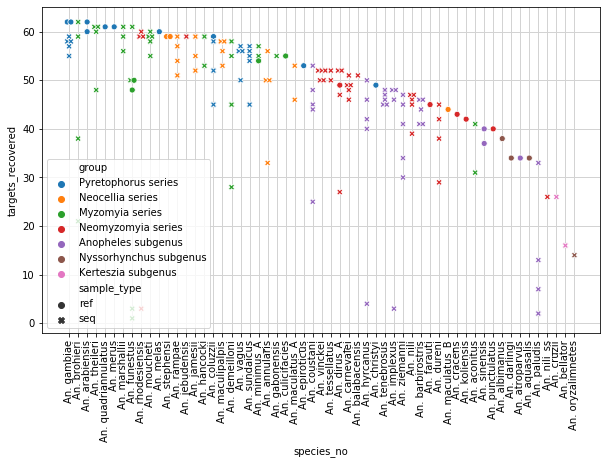

In [20]:
ampl_counts['sample_type'] = ampl_counts.s_Sample.str.startswith('anopheles').replace({True:'ref',False:'seq'})

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.grid(b=True, which='major', color='lightgrey', linewidth=1.0)
ax.set_axisbelow(True)
sns.scatterplot(data = ampl_counts,
                x='species_no',
                y='targets_recovered',
                hue='group',
                style='sample_type',
#                 x_jitter=1, 
                hue_order=('Pyretophorus series','Neocellia series',
                         'Myzomyia series','Neomyzomyia series',
                         'Anopheles subgenus','Nyssorhynchus subgenus',
                         'Kerteszia subgenus'),
                ax=ax)

ax.set_xticks(range(len(all_spp)))
ax.set_xticklabels(all_spp, rotation=90);
# sns.swarmplot(x='species', 
#               y='targets_recovered',
#               hue='group',
#               marker='v',
#               hue_order=('Pyretophorus series','Neocellia series',
#                          'Myzomyia series','Neomyzomyia series',
#                          'Anopheles subgenus','Nyssorhynchus subgenus',
#                          'Kerteszia subgenus'),
#               data=ampl_counts[ampl_counts.s_Sample.str.startswith('anopheles')], ax=ax)
# sns.swarmplot(x='species', 
#               y='targets_recovered',
#               hue='group',
#               marker='v',
#               hue_order=('Pyretophorus series','Neocellia series',
#                          'Myzomyia series','Neomyzomyia series',
#                          'Anopheles subgenus','Nyssorhynchus subgenus',
#                          'Kerteszia subgenus'),
#               data=ampl_counts[~ampl_counts.s_Sample.str.startswith('anopheles')], ax=ax)
# plt.xticks();

## Heterozygosity

In [21]:
# alleles per sample-target combination
ac = miseq.groupby(['s_Sample','target'])['consensus'].nunique()
# heterozygosity as more than one allele
(ac > 1).sum() / ac.shape[0]

0.37177814029363787

In [22]:
(ac == 0).sum(), (ac == 1).sum(), (ac == 2).sum(), (ac > 2).sum(), ac.shape[0]

(0, 3851, 2104, 175, 6130)

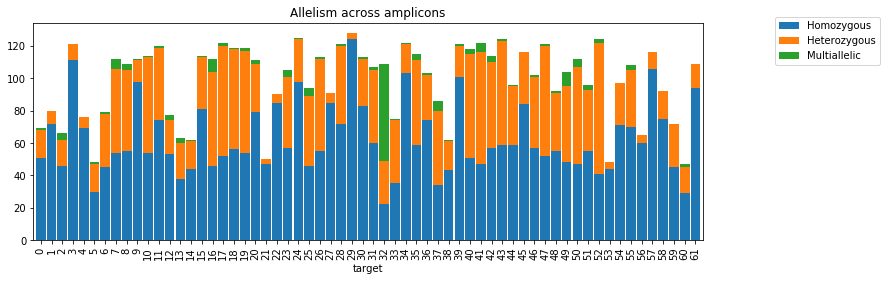

In [23]:
# alleles per sample-target combination
ac = miseq.groupby(['s_Sample','target'])['consensus'].nunique()
# allele counts
ac = ac.unstack()
mean_ac = ac.mean()
std_ac = ac.std()
# combine all multiallelic calls
ac[ac > 2] = 3
# count values
ac = ac.apply(pd.Series.value_counts).T
# normalise
# ac = ac.apply(lambda x: x / x.sum(), axis=1)
# plot
ac.columns='Homozygous Heterozygous Multiallelic'.split()
ac.plot.bar(stacked=True, figsize=(12,4), width=0.9);
plt.title('Allelism across amplicons')
plt.legend(bbox_to_anchor=(1.1, 1.05))

plt.show()

In [24]:
# set up exon-intron plotting settings
exon_c = 'orangered'
intron_c = 'gold'
inter_c = 'royalblue'
# exon vs intergenic
annot = (panel_data.intergenic == 'Yes').replace({True:inter_c,False:exon_c})
annot.loc[panel_data.intron == 'Yes'] = intron_c
annot = annot.to_list()
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color=exon_c, label='Exon')
green_patch = mpatches.Patch(color=intron_c, label='Intron')
blue_patch = mpatches.Patch(color=inter_c, label='Intergenic')

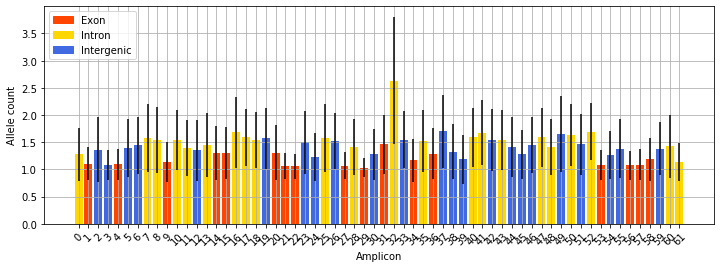

In [25]:
fig, ax = plt.subplots(1,1, figsize=(12,4))
b = ax.bar(range(62), height=mean_ac, yerr=std_ac, color=annot);
ax.set_xlabel('Amplicon')
ax.set_ylabel('Allele count')
ax.legend(handles=[red_patch,green_patch,blue_patch], loc=2)
ax.grid()
plt.xticks(range(62), rotation=45);

# Explore alignments

In [26]:
import Bio
# read alignments and distance matrices
aln_data = dict()
for ampl in AMPLS:
    aln = AlignIO.read(open(ALN_ALL.format(ampl)), 'fasta', alphabet=Bio.Alphabet.generic_dna)
    for record in aln:
        record.seq = record.seq.upper()
    aln_data[ampl] = aln

## Gaps in alignment vs number of sequences

In [27]:
# how gappy are alignments?
ngaps = list()
for ampl in AMPLS:
    a = aln_data[ampl]
    ngaps.append([str(s.seq).count('-') for s in a])

In [28]:
# estimate means and stds
mean_gaps = [np.mean(g) for g in ngaps]
std_gaps = [np.std(g) for g in ngaps]
nseq = [len(g) for g in ngaps]

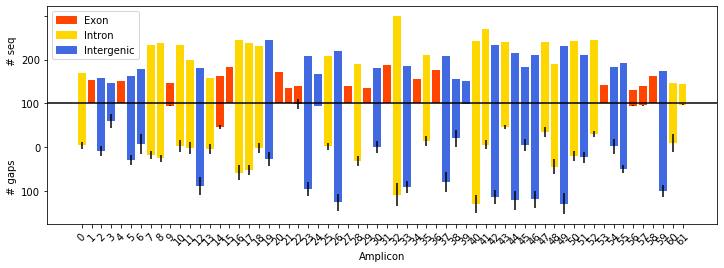

In [29]:
fig, ax = plt.subplots(1,1, figsize=(12,4))
b = ax.bar(range(62), height=[-g for g in mean_gaps], yerr=std_gaps, color=annot);
ns = ax.bar(range(62), height=nseq, color=annot);
ax.set_xlabel('Amplicon')
ax.set_ylabel('# gaps{}# seq'.format(' '*30))
ax.axhline(0,c='k')
ax.set_yticklabels([200,100,0,100,200])
# ax.grid()
ax.legend(handles=[red_patch,green_patch,blue_patch], loc=2)
plt.xticks(range(62), rotation=45);

## Sequence diversity

In [30]:
# collect dists
dists = list()
for ampl in AMPLS:
    a = aln_data[ampl]
    # need for blastn and trans DNA models to work
#     for record in a:
#         record.seq = str(record.seq).replace('N','-')
    l = a.get_alignment_length()
    # get distance matrix
    dm = DistanceCalculator('identity').get_distance(a).matrix
    # flatten
    d = [item for sublist in dm for item in sublist]
    # remove zeroes, multiply by lengths
    d = [i * l for i in d if i > 0]
    dists.append(d)

In [31]:
# get mean and sd
mean_dists = [np.mean(d) for d in dists]
std_dists = [np.std(d) for d in dists]

Text(0, 0.5, 'Pairwise dists')

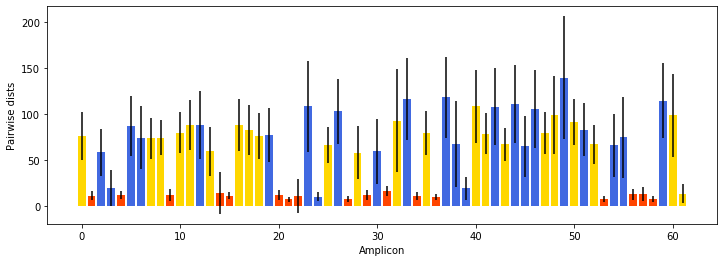

In [32]:
fig, ax = plt.subplots(1,1, figsize=(12,4))
b = ax.bar(range(62), height=mean_dists, yerr=std_dists, color=annot);
ax.set_xlabel('Amplicon')
ax.set_ylabel('Pairwise dists')

## combined plot

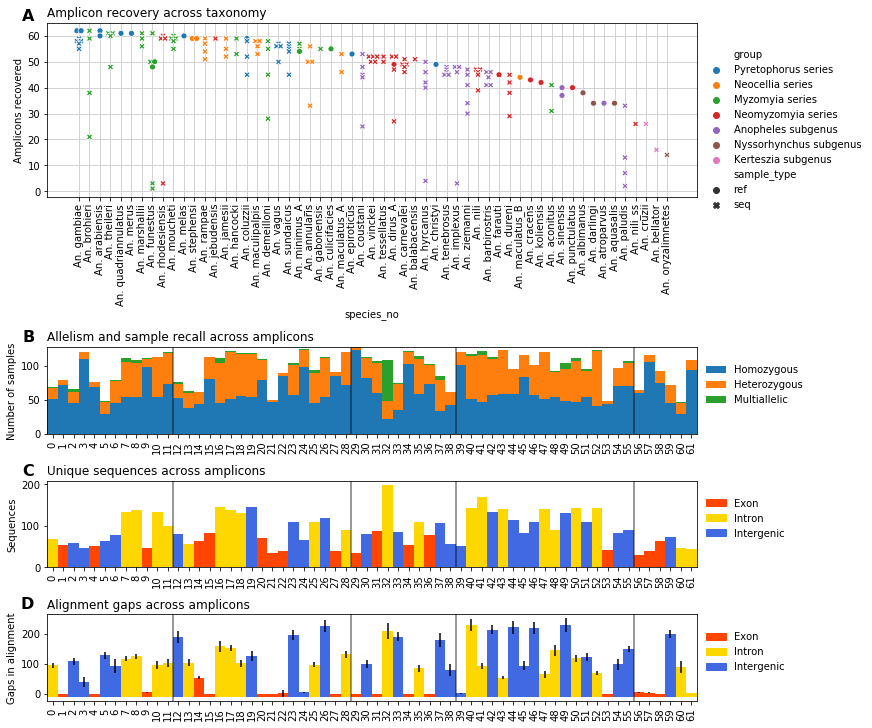

In [33]:
from matplotlib import lines

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, 
                                    figsize=(12,10), 
                                    constrained_layout=True,
                                    gridspec_kw={'height_ratios':(2,1,1,1)})

w = 1
# split chromosomes
for ax in (ax2, ax3, ax4):
    ax.axvline(11.5, c='k', lw=2, alpha=.4)
    ax.axvline(28.5, c='k', lw=2, alpha=.4)
    ax.axvline(38.5, c='k', lw=2, alpha=.4)
    ax.axvline(55.5, c='k', lw=2, alpha=.4)
# subplot 1
sns.scatterplot(data = ampl_counts,
                x='species_no',
                y='targets_recovered',
                hue='group',
                style='sample_type',
                hue_order=('Pyretophorus series','Neocellia series',
                         'Myzomyia series','Neomyzomyia series',
                         'Anopheles subgenus','Nyssorhynchus subgenus',
                         'Kerteszia subgenus'),
                ax=ax1)

ax1.set_xticks(range(len(all_spp)))
ax1.set_xticklabels(all_spp, rotation=90)
ax1.grid(b=True, which='major', color='lightgrey', linewidth=1.0)
ax1.set_axisbelow(True)
ax1.set_title('Amplicon recovery across taxonomy', loc='left')
ax1.set_ylabel('Amplicons recovered')
ax1.legend(bbox_to_anchor=(1, 0.9), frameon=False)
# subplot 2
ac.plot.bar(stacked=True, width=w, ax=ax2);
ax2.set_ylabel('Number of samples')
ax2.legend(bbox_to_anchor=(1, 0.9), frameon=False)
ax2.set_xlabel('')
ax2.set_xticklabels(range(62), rotation=90)
ax2.set_title('Allelism and sample recall across amplicons', loc='left')
# subplot 3
ax3.bar(range(62), width=w, height=nseq, color=annot);
ax3.set_xlabel('Amplicon')
ax3.set_xticks(range(62))
ax3.set_xticklabels(range(62), rotation=90)
ax3.set_xlabel('')
ax3.set_ylabel('Sequences')
ax3.legend(handles=[red_patch,green_patch,blue_patch], bbox_to_anchor=(1, 0.9), frameon=False)
ax3.set_title('Unique sequences across amplicons', loc='left')
# subplot 4
ax4.bar(range(62), height=[g+10 for g in mean_gaps], bottom=-10, yerr=std_gaps, color=annot, width=w);
ax4.set_xlabel('Amplicon')
ax4.set_xticks(range(62))
ax4.set_xticklabels(range(62), rotation=90)
ax4.set_ylabel('Gaps in alignment')
ax4.set_xlabel('')
ax4.legend(handles=[red_patch,green_patch,blue_patch], bbox_to_anchor=(1, 0.9), frameon=False)
ax4.set_title('Alignment gaps across amplicons', loc='left')
# shared axes
ax2.get_shared_x_axes().join(ax2, ax3, ax4)
ax2.autoscale(tight=True)
# labels
for label, ax, yloc in zip('A B C D'.split(), (ax1, ax2, ax3, ax4), (1.08, 1.2, 1.2, 1.2)):
    ax.text(-0.02, yloc, label, transform=ax.transAxes,
          fontsize=16, fontweight='bold', va='top', ha='right')

    
plt.savefig('data/fig2.pdf')
plt.show()

## Combine sample metadata with sequencing stats

In [34]:
comb_meta = meta.set_index('s_Sample')
comb_meta['Total Reads'] = seq.groupby('s_Sample')['reads'].sum()
comb_meta['Amplicons Recovered'] = seq.groupby('s_Sample')['target'].nunique()
# using count instead of nunique to account for perfect repetitions in reference genomes
ac = seq.groupby(['s_Sample','target'])['consensus'].count().unstack()
comb_meta['Homozygous Calls'] = (ac == 1).sum(axis=1)
comb_meta['Heterozygous Calls'] = (ac == 2).sum(axis=1)
comb_meta['Multiallelic Calls'] = (ac > 2).sum(axis=1)

In [35]:
comb_meta.to_csv(COMB_SEQ_META)